# Train MPOX detection models

Based on theh paper *"Deep learning based detection of monkeypox virus using skin lesion images"* by T. Nayak et al., 2023

Will fine tune a CNN model:
- Dataset: Monkeypox Dataset 2022 (binary)
- Pretrained model: ResNet-18 trained with Imagenet-1k

## Imports and Setup

In [1]:
from eccore.ipython import nb_setup
nb_setup()

import matplotlib.pyplot as plt
import re
import torch
import umap

from pprint import pprint
from uuid import uuid4
from IPython.display import Markdown, display


from fastai import __version__ as fastai_version
from fastai.vision.all import *
from fastai.callback.all import ShowGraphCallback
from pathlib import Path
from utils import run_experiment, create_image_features, plot_features, parse_saved_fnames, ROOT, DATASETS
from utils import validate_models, plot_training_and_validation_metrics, model_weight_files

print(f"Using fastai version {fastai_version}")
saved = ROOT / "saved"
data = ROOT / "data"

train_ds = "mpox-ds-2022-binary"
p2train_ds = DATASETS[train_ds]['path']
assert p2train_ds.is_dir(), f"Training dataset path {p2train_ds} is not a directory."
print(f"This notebook will use {train_ds} training dataset ({p2train_ds})")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# styles = plt.style.available
plt.style.use('default')

Added path: /home/vtec/projects/bio/mpox-prestudy/src
Set autoreload mode
Using fastai version 2.8.3
This notebook will use mpox-ds-2022-binary training dataset (/home/vtec/projects/bio/mpox-prestudy/data/Monkeypox-dataset-2022-binary)
Using device: cuda


Review the training dataset for finetuning

In [2]:
imgs_train_ds = get_image_files(p2train_ds)
imgs_mpox = get_image_files(p2train_ds / "Monkeypox")
imgs_others = get_image_files(p2train_ds / "Others")
print(f"Training dataset ({train_ds}): {len(imgs_train_ds):,} images found in {p2train_ds}")
print(f" - Monkeypox: {len(imgs_mpox):,} images")
print(f" - Others:    {len(imgs_others):,} images")

Training dataset (mpox-ds-2022-binary): 1,425 images found in /home/vtec/projects/bio/mpox-prestudy/data/Monkeypox-dataset-2022-binary
 - Monkeypox: 587 images
 - Others:    838 images


Quick review of the training dataset

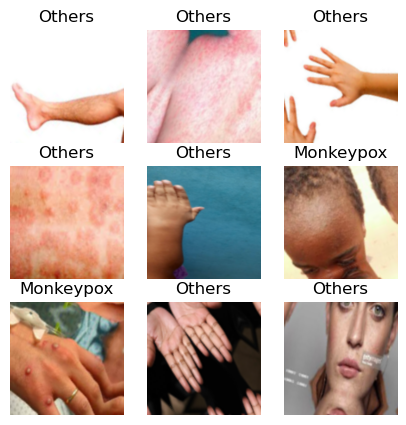

In [3]:
dls = ImageDataLoaders.from_folder(
    path=p2train_ds,
    valid_pct=0.2,
    item_tfms=Resize(224),
    bs=32
)
dls.show_batch(max_n=9, figsize=(5,5), show=True)

In [ ]:
# run_experiment(resnet18, train_ds='msld-v1', freeze_epochs=1, n_epoch=4, lr=1e-3, bs=32, suggested_lr='minimum', save_records=False)

## Fine tune model (resnet18)

Running experiment 1/1: bs=32; lr=5e-05
resnet18_100_32_5.0e-05_mpox-ds-2022-binary
> Fine-tuning resnet18 on mpox-ds-2022-binary for 100 epochs with batch size 32 ...


epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,1.225244,0.749871,0.567901,0.681481,0.603509,0.619529,00:02


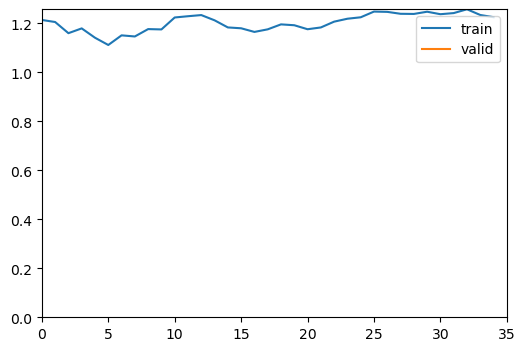

epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,1.153393,0.717231,0.598765,0.692857,0.621053,0.642384,00:02
1,1.071098,0.721003,0.549383,0.706349,0.614035,0.618056,00:02
2,1.053397,0.669758,0.617284,0.729927,0.652632,0.668896,00:02
3,1.012466,0.644801,0.623457,0.742647,0.663158,0.677852,00:00
4,0.980541,0.633745,0.604938,0.771654,0.673684,0.678201,00:03
5,0.931106,0.607070,0.617284,0.769231,0.677193,0.684932,00:02
6,0.899594,0.583555,0.654321,0.785185,0.701754,0.713805,00:02
7,0.880111,0.575111,0.666667,0.812030,0.722807,0.732203,00:02
8,0.860592,0.564126,0.672840,0.807407,0.722807,0.734007,00:02
9,0.827262,0.540226,0.691358,0.817518,0.736842,0.749164,00:02


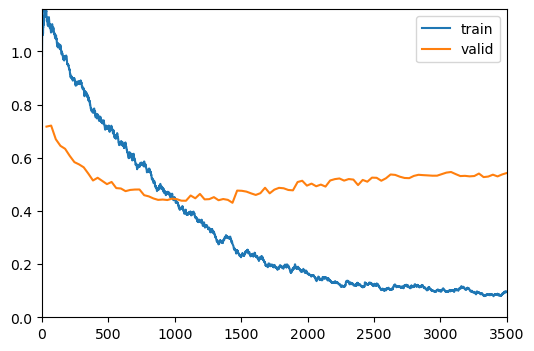

> Training records not saved
----------------------------------------



In [6]:
freeze_epochs = 1
n_epoch = 100
SAVE_RECORDS = True
SAVE_RECORDS = False

hyperparams = (
    (5e-5, 32),
    # (None,16),
    # (None,64),
    # (None,32)
)

for i, (lr, bs) in enumerate(hyperparams):
    print(f"Running experiment {i+1}/{len(hyperparams)}: bs={bs}; lr={lr}")
    learn = run_experiment(
        resnet18,
        train_ds='mpox-ds-2022-binary',
        freeze_epochs=freeze_epochs, 
        n_epoch=n_epoch, 
        lr=lr, 
        bs=bs,
        suggested_lr='steep',
        save_records=SAVE_RECORDS
    )
    print(f"{'-'*40}\n")

## Validate model

In [ ]:
selected_arch = resnet18
training_ds = 'mpox-ds-2022-binary'
validation_ds = 'msid-binary'

training_res_df, validation_res_df = validate_models(
    arch=selected_arch,
    training_ds=training_ds,
    validation_ds=validation_ds,
)

In [ ]:
plot_training_and_validation_metrics(training_res_df, validation_res_df)

# Others

In [ ]:
from PIL import Image

In [ ]:
p2img_dir = data / 'MSLD-v1/Original/Monkeypox'

# img = Image.open(p2img_dir / 'M01_01.jpg')
# img = Image.open(p2img_dir / 'M08_01.jpg')
img = Image.open(p2img_dir / 'M26_01.jpg')
# img = Image.open(p2img_dir / 'M49_02.jpg')
print(img.size)
img_384 = img.resize((384, 384), Image.LANCZOS)
img_384.save(data / f"{Path(img.filename).stem}_384.jpg")
img_1024 = img.resize((1024, 1024), Image.LANCZOS)
img_1024.save(data / f"{Path(img.filename).stem}_1024.jpg")